In [1]:
from pathlib import Path
from glob import glob
import pandas as pd
import numpy as np

from alternationprober.constants import (
    PATH_TO_BERT_WORD_EMBEDDINGS_FILE,
    PATH_TO_BERT_CONTEXT_WORD_EMBEDDINGS_FILE,
    PATH_TO_LAVA_DIR,
    PATH_TO_LAVA_VOCAB,
    PATH_TO_RESULTS_DIRECTORY,
)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
experiment_results = PATH_TO_RESULTS_DIRECTORY / "linear-probe-for-word-embeddings"

layer_paths = experiment_results.glob("*/")
layer_paths = [path for path in layer_paths if path.is_dir()]

In [3]:
layer_dfs = []
for i, layer_path in enumerate(layer_paths):
    df_list = []
    for alternation_csv in layer_path.glob("*.csv"):
        df = pd.read_csv(alternation_csv)
        df_list.append(df)
    layer_df = pd.concat(df_list, axis=0)
    # Static embeddings correspond to layer 0
    if layer_path.stem == 'static':
        layer_df['layer'] = 0
    else:
        layer_df['layer'] = i + 1
    layer_dfs.append(layer_df)
all_df = pd.concat(layer_dfs, axis=0)

# Frames in the order they appear in the paper
frames = ['inch', 'non_inch', 'dative_to', 'dat_do', 'sl_noloc', 'sl_nowith', 'non_there', 'there', 'refl_only', 'refl_op']
all_df = all_df[all_df['alternation_class'].isin(frames)]

In [4]:
# Reference MRRs from the CoLA MLP Model
ref_mcc = [0.555, 0, 0.32, 0.482, 0.645, 0.253, 0.459, 0, 0, 0.219]
ref = {frame:mcc for frame, mcc in zip(frames, ref_mcc)}
ref

{'inch': 0.555,
 'non_inch': 0,
 'dative_to': 0.32,
 'dat_do': 0.482,
 'sl_noloc': 0.645,
 'sl_nowith': 0.253,
 'non_there': 0.459,
 'there': 0,
 'refl_only': 0,
 'refl_op': 0.219}

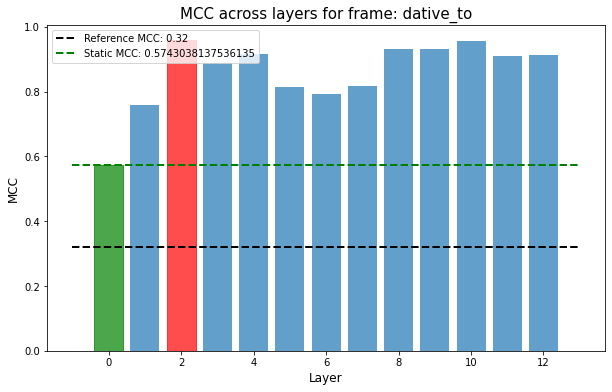

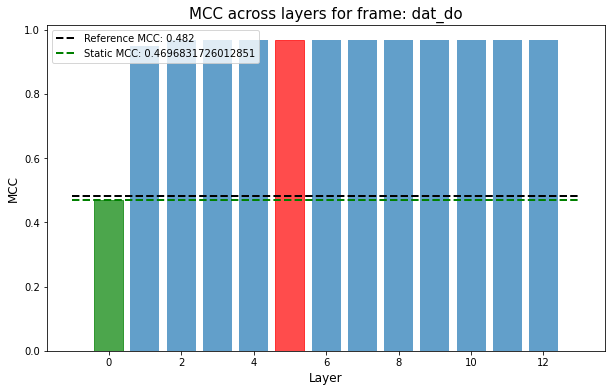

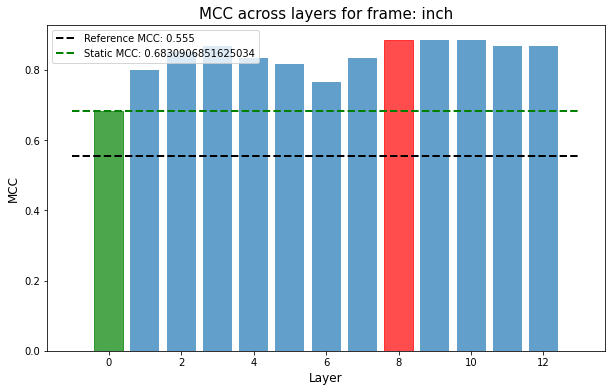

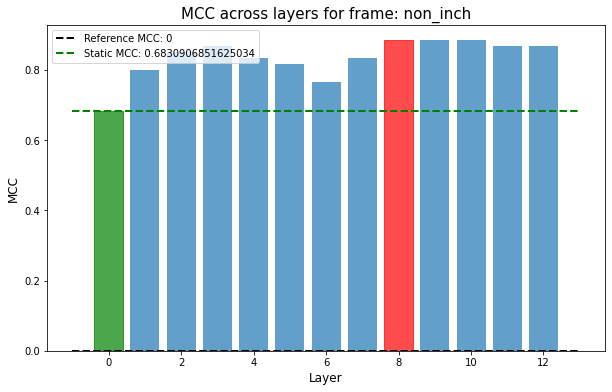

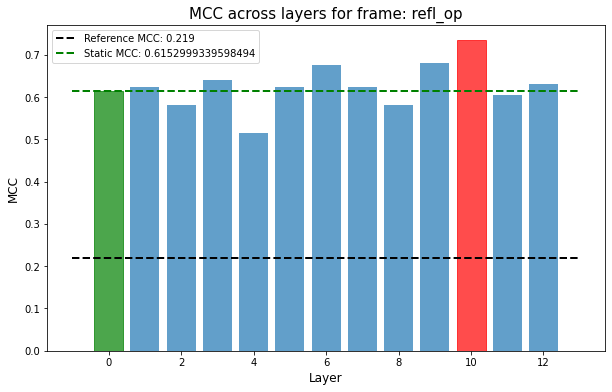

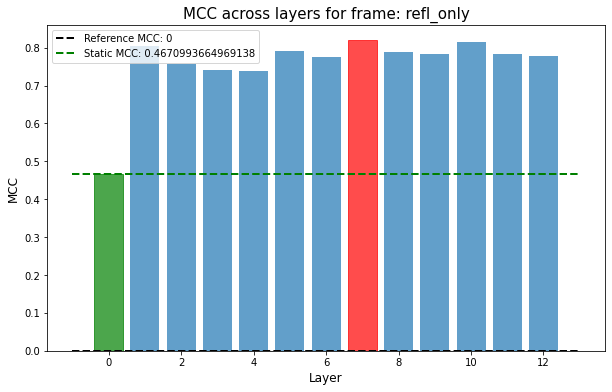

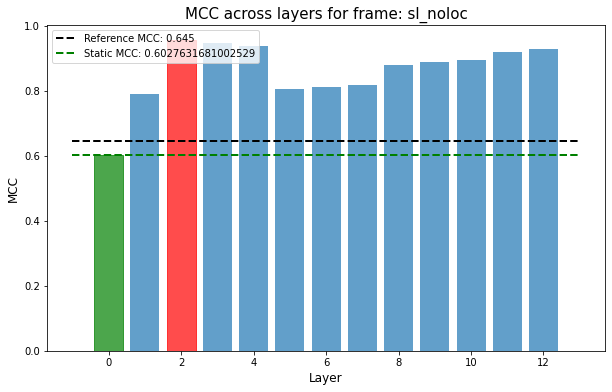

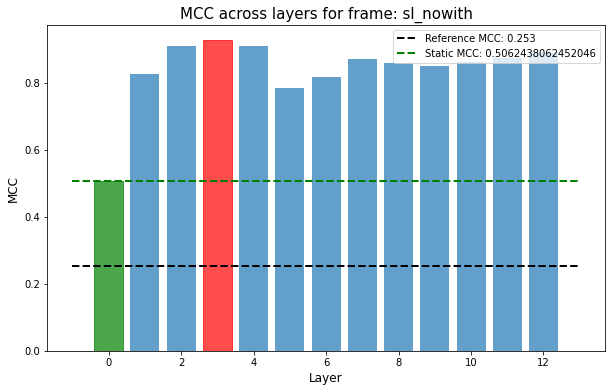

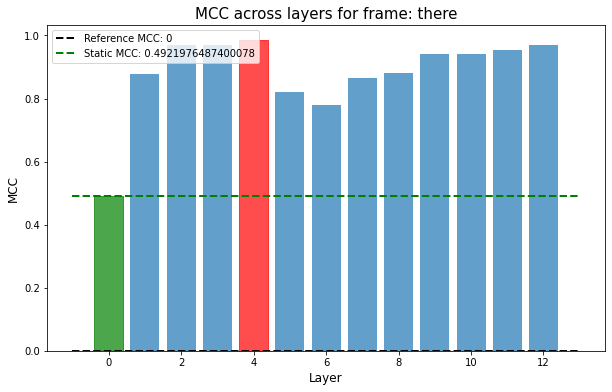

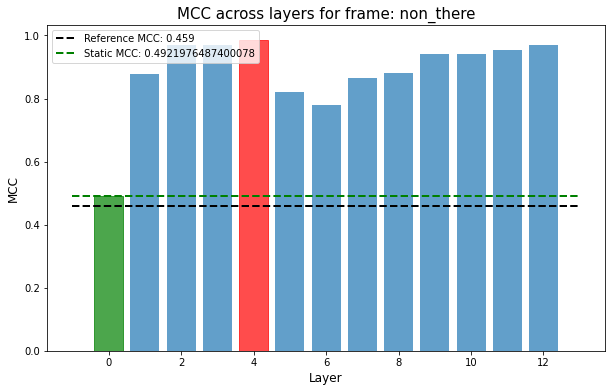

In [5]:
best_layers = []
best_mccs = []
static_mccs = []
best_accs = []
baseline_accs = []
for alternation in all_df['alternation_class'].unique():
    alternation_df = all_df[all_df['alternation_class'] == alternation].reset_index()
    
    # Store variables to create summary df
    best_layer = alternation_df.mcc.argmax()
    best_layers.append(best_layer)
    best_mcc = alternation_df['mcc'][best_layer]
    best_mccs.append(best_mcc)
    best_accs.append(alternation_df['accuracy'][best_layer])
    baseline_accs.append(alternation_df['baseline_accuracy'][best_layer])
    static_mcc = alternation_df[alternation_df['layer'] == 0]['mcc'].item()
    static_mccs.append(static_mcc)

    # Create barplot
    plt.figure(figsize=(10, 6))
    fig = plt.bar(alternation_df.layer, alternation_df.mcc, alpha=0.7)
    fig[best_layer].set_color('r')
    fig[-1].set_color('g')

    # Reference MCC Baseline
    plt.hlines(y=ref[alternation], xmin=-1, xmax=13, linestyles='--', lw=2, color='black', label=f'Reference MCC: {ref[alternation]}')
    # Static MCC Baseline
    plt.hlines(y=static_mcc, xmin=-1, xmax=13, linestyles='--', lw=2, color='green', label=f'Static MCC: {static_mcc}')

    plt.title(f'MCC across layers for frame: {alternation}', fontsize=15)
    plt.xlabel('Layer', fontsize=12)
    plt.ylabel('MCC', fontsize=12)
    plt.legend()
    plt.show()

<AxesSubplot:xlabel='Frame', ylabel='Layer'>

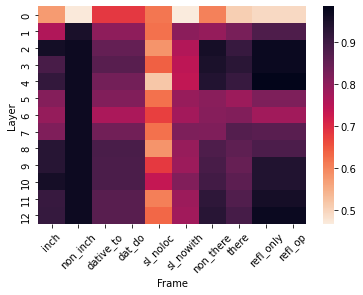

In [7]:
# Heatmap of layer performance
layer_mccs = np.array(all_df.groupby('layer')[['mcc']].agg(list).reset_index()['mcc'].values.tolist())
map = sns.heatmap(layer_mccs, xticklabels=frames, cmap="rocket_r")
plt.xlabel('Frame')
plt.ylabel('Layer')
plt.xticks(rotation=45)
map

In [8]:
pd.DataFrame(data={
    'Frame': frames, 
    'BERT layer': best_layers,
    'Layer MCC': best_mccs,
    'Reference MCC': ref_mcc,
    'Static MCC': static_mccs, 
    'Baseline Accuracy': baseline_accs,
    'Accuracy': best_accs
    }
)

,Frame,BERT layer,Layer MCC,Reference MCC,Static MCC,Baseline Accuracy,Accuracy
0,inch,1,0.958468,0.555,0.574304,0.945701,0.995475
1,non_inch,4,0.967252,0.000,0.469683,0.925339,0.995475
2,dative_to,7,0.883893,0.320,0.683091,0.588710,0.943548
3,dat_do,7,0.883893,0.482,0.683091,0.588710,0.943548
4,sl_noloc,9,0.734297,0.645,0.615300,0.974806,0.988372
5,sl_nowith,6,0.819723,0.253,0.467099,0.833333,0.951550
6,non_there,1,0.955865,0.459,0.602763,0.790087,0.985423
7,there,2,0.926923,0.000,0.506244,0.833819,0.979592
8,refl_only,3,0.984987,0.000,0.492198,0.664430,0.993289
9,refl_op,3,0.984987,0.219,0.492198,0.664430,0.993289
